In [1]:
pip install kmodes catboost scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 1.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import json
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# ---------------------------------------------------------------
# 1️⃣ Load Dataset
# ---------------------------------------------------------------
df = pd.read_csv("persona_template_dataset_v4.csv")
print("✅ Loaded dataset:", df.shape)


✅ Loaded dataset: (5000, 7)


In [3]:
# ---------------------------------------------------------------
# 2️⃣ Basic Preprocessing
# ---------------------------------------------------------------
for col in ["gender", "occupation", "education_level", "device_type"]:
    df[col] = df[col].astype(str)

df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["daily_usage_hours"] = pd.to_numeric(df["daily_usage_hours"], errors="coerce")
df.dropna(subset=["age", "daily_usage_hours"], inplace=True)

# ---------------------------------------------------------------
# 3️⃣ Feature Setup
# ---------------------------------------------------------------
features = ["age", "gender", "occupation", "education_level", "device_type", "daily_usage_hours"]
X = df[features].copy()
cat_cols_idx = [X.columns.get_loc(col) for col in ["gender", "occupation", "education_level", "device_type"]]


🔍 Finding optimal cluster count (4–10)...
k=4, silhouette=0.5114
k=5, silhouette=0.4773
k=6, silhouette=0.4467
k=7, silhouette=0.4228
k=8, silhouette=0.3937
k=9, silhouette=0.3708
k=10, silhouette=0.3448


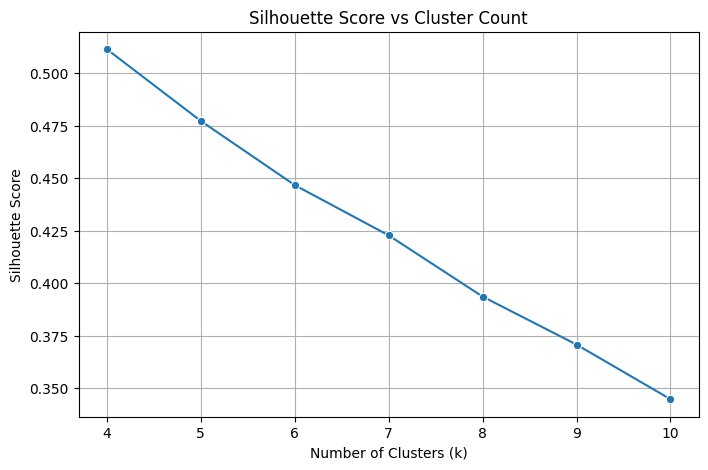


✅ Best cluster count = 4 (Silhouette=0.511)


In [4]:
# ---------------------------------------------------------------
# 4️⃣ Find Optimal Cluster Count
# ---------------------------------------------------------------
print("\n🔍 Finding optimal cluster count (4–10)...")
sil_scores = {}
for k in range(4, 11):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_jobs=-1, random_state=42)
    clusters = kproto.fit_predict(X, categorical=cat_cols_idx)
    score = silhouette_score(pd.get_dummies(X), clusters)
    sil_scores[k] = score
    print(f"k={k}, silhouette={score:.4f}")

# Plot Silhouette Scores
plt.figure(figsize=(8,5))
sns.lineplot(x=list(sil_scores.keys()), y=list(sil_scores.values()), marker='o')
plt.title("Silhouette Score vs Cluster Count")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

best_k = max(sil_scores, key=sil_scores.get)
print(f"\n✅ Best cluster count = {best_k} (Silhouette={sil_scores[best_k]:.3f})")

# ---------------------------------------------------------------
# 5️⃣ Fit Final Model
# ---------------------------------------------------------------
kproto = KPrototypes(n_clusters=best_k, init='Cao', n_jobs=-1, random_state=42)
clusters = kproto.fit_predict(X, categorical=cat_cols_idx)
df["cluster"] = clusters



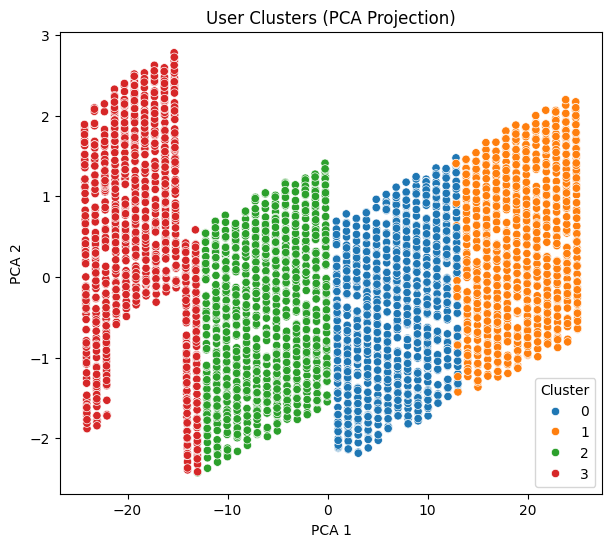

/tmp/ipython-input-4009622333.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="cluster", data=df, palette="coolwarm")


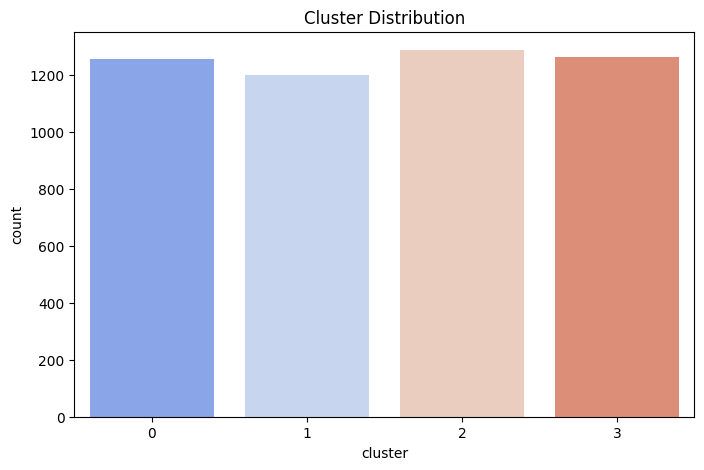

In [5]:
# ---------------------------------------------------------------
# 6️⃣ Save Model
# ---------------------------------------------------------------
with open("kproto_model.pkl", "wb") as f:
    pickle.dump(kproto, f)

# ---------------------------------------------------------------
# 7️⃣ Visualize Clusters (PCA)
# ---------------------------------------------------------------
X_encoded = pd.get_dummies(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_encoded)

plt.figure(figsize=(7,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df["cluster"], palette="tab10")
plt.title("User Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x="cluster", data=df, palette="coolwarm")
plt.title("Cluster Distribution")
plt.show()



In [6]:
# ---------------------------------------------------------------
# 8️⃣ Extract JSON Templates per Cluster
# ---------------------------------------------------------------
cluster_templates = {}
for c in df["cluster"].unique():
    cluster_data = df[df["cluster"] == c]["template"]
    collected = []
    for temp in cluster_data:
        try:
            parsed = json.loads(temp.replace("'", '"'))
            collected.extend(parsed)
        except Exception:
            continue

    if collected:
        names = pd.Series([t["name"] for t in collected])
        top_names = names.value_counts().head(3).index.tolist()
        top_templates = [t for t in collected if t["name"] in top_names][:3]
        cluster_templates[c] = top_templates
    else:
        cluster_templates[c] = []

print("\n📋 Top Templates per Cluster:")
for c, temps in cluster_templates.items():
    print(f"Cluster {c}: {[t['name'] for t in temps]}")




📋 Top Templates per Cluster:
Cluster 0: ['Work Tasks', 'Personal To-Do', 'Work Tasks']
Cluster 2: ['Personal To-Do', 'Work Tasks', 'Personal To-Do']
Cluster 1: ['Personal To-Do', 'Work Tasks', 'Personal To-Do']
Cluster 3: ['Work Tasks', 'Personal To-Do', 'Work Tasks']


In [7]:
# ---------------------------------------------------------------
# 9️⃣ Recommendation Function
# ---------------------------------------------------------------
def recommend_templates(new_user_dict):
    data = pd.DataFrame([new_user_dict])[features]
    cluster_label = kproto.predict(data.values, categorical=cat_cols_idx)[0]
    recommendations = cluster_templates.get(cluster_label, [])
    return {
        "predicted_cluster": int(cluster_label),
        "recommended_templates": recommendations
    }

# ---------------------------------------------------------------
# 🔟 Example Recommendation
# ---------------------------------------------------------------
new_user = {
    "age": 27,
    "gender": "Female",
    "occupation": "Data Analyst",
    "education_level": "Bachelor's",
    "device_type": "Laptop",
    "daily_usage_hours": 7.0
}

recommendation = recommend_templates(new_user)
print("\n🎯 Recommended Templates for New User:")
print(json.dumps(recommendation, indent=2))



🎯 Recommended Templates for New User:
{
  "predicted_cluster": 3,
  "recommended_templates": [
    {
      "name": "Work Tasks",
      "type": "table",
      "columns": [
        {
          "name": "Task",
          "type": "text"
        },
        {
          "name": "Status",
          "type": "options",
          "options": [
            "In Progress",
            "Completed"
          ]
        },
        {
          "name": "Priority",
          "type": "options",
          "options": [
            "High",
            "Medium",
            "Low"
          ]
        },
        {
          "name": "Due Date",
          "type": "date"
        }
      ],
      "values": [
        [
          "Code Review",
          "In Progress",
          "Low",
          "2025-11-24"
        ],
        [
          "Team Meeting",
          "Completed",
          "Low",
          "2025-11-29"
        ],
        [
          "Report Writing",
          "Completed",
          "High",
          "2025

In [8]:
# ---------------------------------------------------------------
# 🔢 11 Model Evaluation Metrics
# ---------------------------------------------------------------
# Silhouette Score (overall quality of clusters)
silhouette_final = silhouette_score(pd.get_dummies(X), df["cluster"])
print(f"\n📊 Final Silhouette Score: {silhouette_final:.3f}")

# Approx. Accuracy (how stable cluster labels are if refit)
# This measures how many users remain in same cluster after slight re-training
kproto_retest = KPrototypes(n_clusters=best_k, init='Cao', n_jobs=-1, random_state=42)
clusters_retest = kproto_retest.fit_predict(X, categorical=cat_cols_idx)
stability = np.mean(clusters == clusters_retest)
print(f"✅ Model Stability (Approx. Accuracy): {stability*100:.2f}%")




📊 Final Silhouette Score: 0.511
✅ Model Stability (Approx. Accuracy): 100.00%
